In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def reReadData():
  df=pd.read_csv('gdrive/My Drive/Data_Version_4.csv',header=0, index_col=0, 
                infer_datetime_format=True, parse_dates=['Date'])
  df['log_ret'] = np.log(df['Russell3000_Adj_Close']) - np.log(df['Russell3000_Adj_Close'].shift(1))
  df = df.dropna()
  df = df[train_start:test_end]
  df_train, df_test = df[train_start:train_end],df[train_end:test_end]
  return df, df_train, df_test


def plotProb_train(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_train.index, df_train['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_train.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def plotProb_test(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_test.index, df_test['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_test.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def labeling(model,threshold1, threshold2):
  bear_regime = 0 if model.params['const[0]'] < model.params['const[1]'] else 1

  label_filtered = []
  
  for i in model.filtered_marginal_probabilities[bear_regime].values:
    if i >= threshold1:
      app = -1
    elif i >= threshold2:
      app = 0
    else:
      app = 1
    label_filtered.append(app)

  label_filtered= np.array(label_filtered)
  
  return label_filtered


def duration(label):

  duration_bull = []
  duration_static = []
  duration_bear = []

  count,prev,trade = 1,1,0

  for i in label:
    if i == prev:
      count+=1
    else:
      trade+=1
      if prev == 1:
        duration_bull.append(count)
        count = 1
      elif prev == 0:
        duration_static.append(count)
        count = 1
      else:
        duration_bear.append(count)
        count = 1
    prev = i
    
  if prev == 1:
    duration_bull.append(count)
  elif prev == 0:
    duration_static.append(count)
  else:
    duration_bear.append(count)

  duration_bull = pd.DataFrame(duration_bull)
  duration_static = pd.DataFrame(duration_static)
  duration_bear = pd.DataFrame(duration_bear)

  return duration_bull, duration_static, duration_bear,trade


def label_train_logret(label):
  return (df_train['log_ret'] * label).sum()

def label_test_logret(label):
  return (df_test['log_ret'] * label).sum()



def Search_train(model, duration_static, duration_bear):
  threshold1, threshold2, record =0,0,0
  for i in range(1,101):
    for j in range(i):
      label_filtered = labeling(model,i/100, j/100)
      if ( (duration(label_filtered))[1].mean().values >= duration_static ):
        if ( (duration(label_filtered))[2].mean().values >= duration_bear ) :
          if ( (df_train['log_ret'] * label_filtered).sum() >= record ):
            threshold1, threshold2, record = i,j,(df_train['log_ret'] * label_filtered).sum()
  return threshold1/100, threshold2/100



In [ ]:
duration_static, duration_bear = 2, 4

## Set time period

In [ ]:
train_start = '2010-01-01'
train_end = '2017-12-31'
test_end = '2020-12-31'

## Read data

In [ ]:
df,df_train,df_test = reReadData()
print(df,df_train,df_test)

             PX_LAST     PX_VOLUME  ...  Russell3000_Volume   log_ret
Date                                ...                              
2010-01-04   2925.36  1.300478e+09  ...                 0.0  0.016581
2010-01-05   2933.82  1.526207e+09  ...                 0.0  0.002887
2010-01-06   2937.47  1.441448e+09  ...                 0.0  0.000871
2010-01-07   2949.90  1.560355e+09  ...                 0.0  0.004177
2010-01-08   2959.37  1.311918e+09  ...                 0.0  0.003207
...              ...           ...  ...                 ...       ...
2020-12-24  12137.42  4.731720e+08  ...           1923800.0  0.002687
2020-12-28  12203.97  1.000688e+09  ...                 0.0  0.005468
2020-12-29  12155.89  9.592605e+08  ...                 0.0 -0.003953
2020-12-30  12189.07  8.921701e+08  ...                 0.0  0.002573
2020-12-31  12248.16  1.075550e+09  ...           3514200.0  0.004761

[2771 rows x 45 columns]             PX_LAST     PX_VOLUME  ...  Russell3000_Volume   log

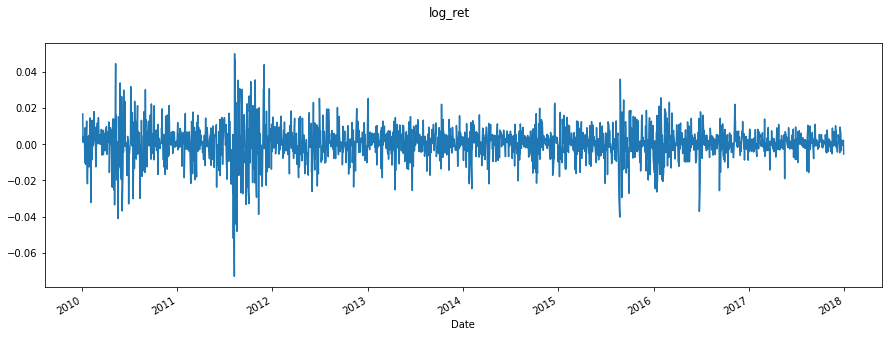

In [ ]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('log_ret')
df_train['log_ret'].plot()
plt.show()

In [ ]:
k=5
name = 'log_ret_MA'+str(k)
df[name] = df['log_ret'].rolling(k).mean()
df = df.dropna()
df = df[train_start:test_end]
df_train, df_test = df[train_start:train_end],df[train_end:test_end]
df

,PX_LAST,PX_VOLUME,T1M,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,CPI_Release,Unemployment_rate,Unemployment_Release,change_in_total_nonfarm_thousand,Nonfarm_Release,VIX_Close,GDP_QOQ_change,GDP_Release,SPY_Adj_Close,SPY_Volume,SP_Adj_Close,SP_Volume,Mkt-RF,SMB,HML,RF,Russell3000_Adj_Close,Russell3000_Volume,log_ret,log_ret_MA5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-08,2959.37,1.311918e+09,0.02,0.05,0.15,0.37,1.56,2.57,3.83,4.70,3.78,2.87,0.25000,0.20,0.11,82.75,0.0011,82.91,0.0027,-104.2377,-83.6834,38.6564,537.355,19.2466,-12.9161,0.3,0.0,9.9,1.0,-269.0,1.0,18.129999,1.5,0.0,90.872749,126402800.0,1144.98,4.389590e+09,0.33,0.37,0.01,0.0,671.489990,0.0,0.003207,0.005545
2010-01-11,2963.29,1.236314e+09,0.01,0.04,0.13,0.35,1.55,2.58,3.85,4.74,3.81,2.90,0.25000,0.21,0.11,82.52,-0.0028,82.04,-0.0105,-104.2377,-83.6834,38.6564,537.355,19.2466,-12.9161,0.3,0.0,9.9,0.0,-269.0,0.0,17.549999,1.5,0.0,90.999641,106375700.0,1146.98,4.255780e+09,0.13,-0.13,-0.25,0.0,672.380005,0.0,0.001325,0.002493
2010-01-12,2933.19,1.445157e+09,0.02,0.05,0.14,0.34,1.50,2.49,3.74,4.62,3.69,2.82,0.25000,0.20,0.11,80.79,-0.0210,80.11,-0.0235,-104.2377,-83.6834,38.6564,537.355,19.2466,-12.9161,0.3,0.0,9.9,0.0,-269.0,0.0,18.250000,1.5,0.0,90.150955,163333500.0,1136.22,4.716160e+09,-1.00,-0.17,-1.28,0.0,665.539978,0.0,-0.010225,-0.000129
2010-01-13,2959.92,1.302675e+09,0.02,0.06,0.15,0.37,1.54,2.55,3.80,4.71,3.74,2.83,0.25000,0.19,0.11,79.65,-0.0141,79.66,-0.0056,-104.2377,-83.6834,38.6564,537.355,19.2466,-12.9161,0.3,0.0,9.9,0.0,-269.0,0.0,17.850000,1.5,0.0,90.912407,161822000.0,1145.68,4.170360e+09,0.85,0.27,0.33,0.0,671.539978,0.0,0.008975,0.001492
2010-01-14,2967.06,1.249217e+09,0.02,0.05,0.14,0.34,1.49,2.51,3.76,4.63,3.71,2.82,0.25000,0.20,0.11,79.39,-0.0033,79.19,-0.0059,-104.2377,-83.6834,38.6564,537.355,19.2466,-12.9161,0.3,0.0,9.9,0.0,-269.0,0.0,17.629999,1.5,0.0,91.158287,115718800.0,1148.46,3.915200e+09,0.24,0.28,0.08,0.0,673.150024,0.0,0.002395,0.001135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,12137.42,4.731720e+08,0.09,0.09,0.09,0.10,0.17,0.37,0.94,1.66,0.85,0.81,0.24013,0.15,0.09,48.23,0.0023,48.28,0.0040,88.0369,-11.9983,67.7990,2187.899,29.4380,-2.1971,0.2,0.0,6.7,0.0,264.0,0.0,21.530001,33.8,0.0,364.146027,26457900.0,3703.06,1.885090e+09,0.21,-0.40,-0.19,0.0,2228.629883,1923800.0,0.002687,-0.000317
2020-12-28,12203.97,1.000688e+09,0.09,0.11,0.11,0.11,0.17,0.38,0.94,1.67,0.83,0.81,0.24013,0.15,0.09,47.62,-0.0126,47.87,-0.0013,129.5575,-7.0556,70.3741,2190.812,29.6935,9.7134,0.2,0.0,6.7,0.0,264.0,0.0,21.700001,33.8,0.0,367.274292,39000400.0,3735.36,3.527460e+09,0.46,-0.73,0.34,0.0,2240.850098,0.0,0.005468,0.001240
2020-12-29,12155.89,9.592605e+08,0.08,0.10,0.12,0.11,0.17,0.37,0.94,1.67,0.84,0.82,0.25388,0.15,0.09,48.00,0.0080,47.94,0.0015,101.9907,-25.4374,66.2470,2195.238,30.1466,3.6515,0.2,0.0,6.7,0.0,264.0,0.0,23.080000,33.8,0.0,366.573639,53680500.0,3727.04,3.387030e+09,-0.40,-1.53,0.24,0.0,2232.010010,0.0,-0.003953,0.001070


## Three regimes, common variance

In [ ]:
hmm0 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=3,trend='c')
hmm0_results = hmm0.fit(search_reps = 100)
print(hmm0_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA5   No. Observations:                 1885
Model:               MarkovRegression   Log Likelihood                8199.044
Date:                Wed, 09 Feb 2022   AIC                         -16378.088
Time:                        04:28:06   BIC                         -16322.671
Sample:                             0   HQIC                        -16357.679
                               - 1885                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.698      0.089   -3.49e-05       0.000
                             Regime 1 parameters    

Note that the transition prob. from bear to static and from bull to static are too high.

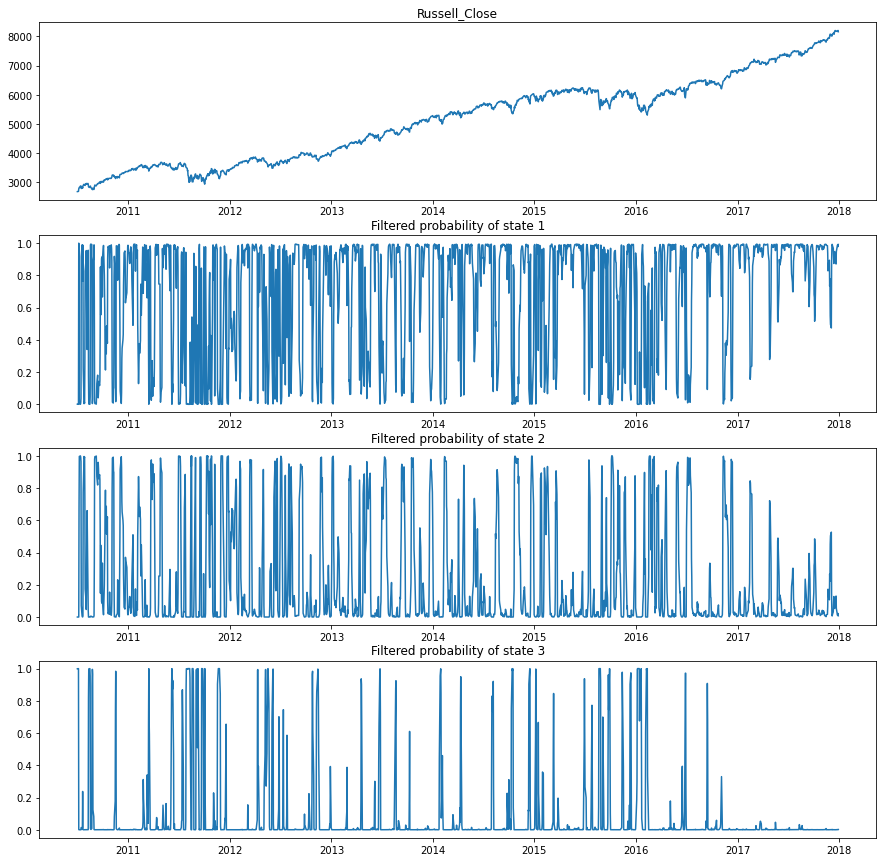

In [ ]:
fig, axes = plt.subplots(4, figsize=(15, 15))

ax = axes[0]
ax.plot(df_train.index, df_train['Russell_Close'])
ax.set(title='Russell_Close')
 
ax = axes[1]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[0])
ax.set(title='Filtered probability of state 1')
 
ax = axes[2]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[1])
ax.set(title='Filtered probability of state 2')

ax = axes[3]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[2])
ax.set(title='Filtered probability of state 3')

plt.show()


## Two regimes, switching mean and variance

In [ ]:
hmm1 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_results = hmm1.fit(search_reps = 100)
print(hmm1_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 2006
Model:               MarkovRegression   Log Likelihood                9548.089
Date:                Wed, 09 Feb 2022   AIC                         -19084.178
Time:                        22:53:45   BIC                         -19050.555
Sample:                             0   HQIC                        -19071.834
                               - 2006                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017   7.81e-05     21.494      0.000       0.002       0.002
sigma2       2.72e-06   1.37e-07     19.857      0.0

In [ ]:
#using the same probability filter constructed from the training set
hmm1_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.99 0.03


In [ ]:
label_filtered_result = labeling(hmm1_results,t1,t2)
print((duration(label_filtered_result))[0].mean())
print((duration(label_filtered_result))[1].mean())
print((duration(label_filtered_result))[2].mean())
print((duration(label_filtered_result))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))

0    9.604167
dtype: float64
0    5.911565
dtype: float64
0    4.153846
dtype: float64
294
0.8549635442250905 2.170308025503185


In [ ]:
np.histogram(label_filtered_result)

(array([216,   0,   0,   0,   0, 869,   0,   0,   0, 921]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

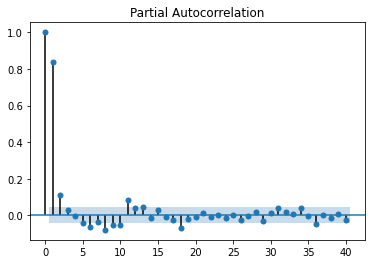

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered_result, lags=40)
plt.show()

In [ ]:
sm.tsa.pacf(label_filtered_result)

array([ 1.00000000e+00,  8.35361344e-01,  1.12229898e-01,  3.09137944e-02,
       -1.34545454e-03, -4.17505793e-02, -6.53876626e-02, -3.46686335e-02,
       -7.92101662e-02, -5.49486275e-02, -5.48633851e-02,  8.57075748e-02,
        3.88882305e-02,  4.38623419e-02, -1.28843947e-02,  2.72877941e-02,
       -8.70045292e-03, -2.47229993e-02, -6.75689360e-02, -2.13270199e-02,
       -7.81727305e-03,  1.33334566e-02, -7.65544091e-03,  3.38708440e-03,
       -1.54660559e-02,  1.04975650e-03, -2.54854170e-02, -8.01331839e-04,
        1.89393850e-02, -2.98327066e-02,  1.20799847e-02,  4.28589347e-02,
        1.83855014e-02,  5.15687509e-03,  4.02163328e-02, -5.30317317e-04,
       -4.62498372e-02,  1.83577057e-03, -1.19091710e-02,  9.07228274e-03,
       -2.37854273e-02])

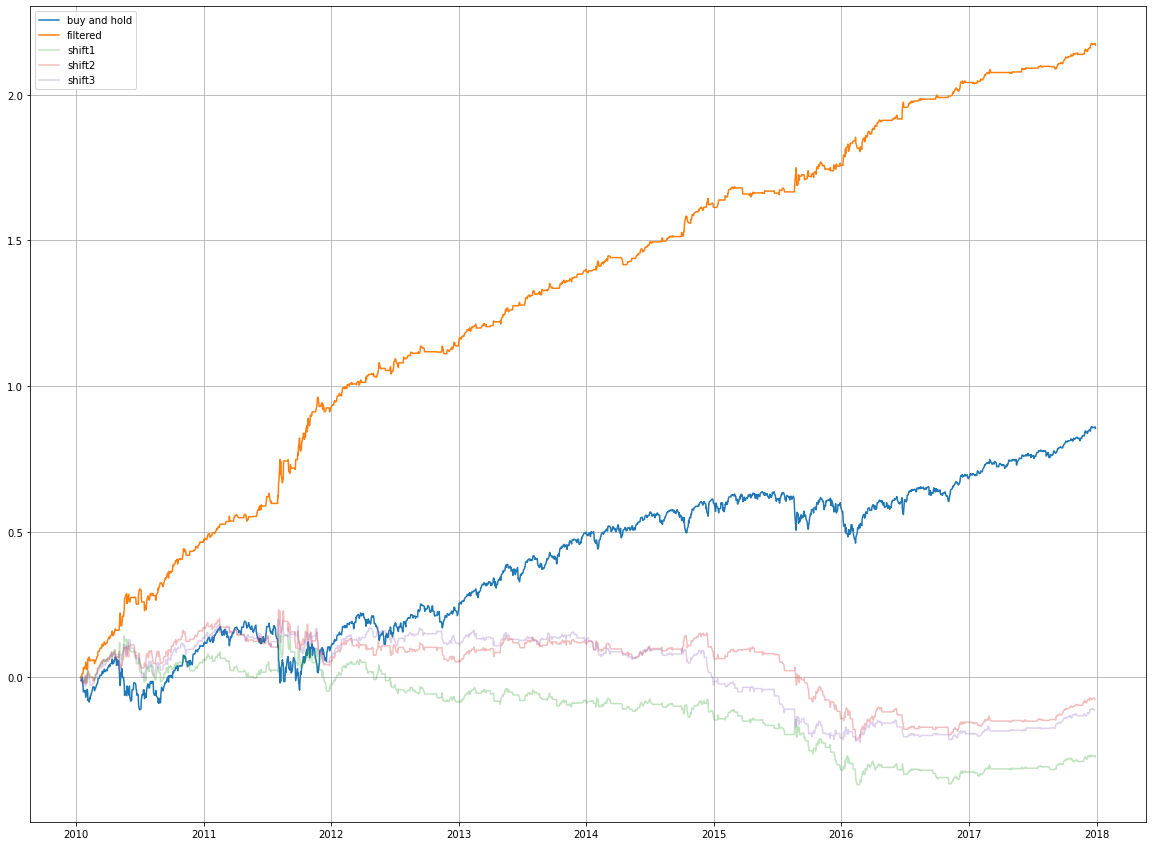

In [ ]:
# training set plot

fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_filtered_result).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_filtered_result).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-2) * label_filtered_result).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-3) * label_filtered_result).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [ ]:
label_filtered_test = labeling(hmm1_test_results,t1,t2)
print((duration(label_filtered_test))[0].mean())
print((duration(label_filtered_test))[1].mean())
print((duration(label_filtered_test))[2].mean())
print((duration(label_filtered_test))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))

0    10.135135
dtype: float64
0    3.875
dtype: float64
0    4.785714
dtype: float64
128
0.3510601274199683 0.9485754234774486


In [ ]:
np.histogram(label_filtered_test)

(array([134,   0,   0,   0,   0, 248,   0,   0,   0, 374]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

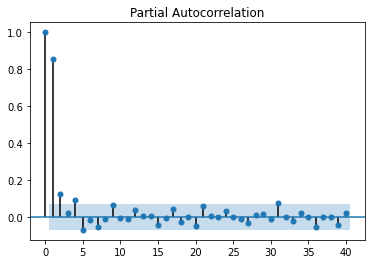

array([ 1.00000000e+00,  8.53417154e-01,  1.24603390e-01,  1.86312031e-02,
        9.13301876e-02, -7.15810038e-02, -1.89335144e-02, -5.34776373e-02,
       -1.32581014e-02,  6.61681799e-02, -6.73061745e-03, -1.46995355e-02,
        3.78101223e-02,  6.38649971e-03,  4.59753772e-03, -4.62303763e-02,
       -4.97189078e-03,  4.40096962e-02, -2.83938707e-02, -2.37203982e-03,
       -5.30032777e-02,  5.66101765e-02,  1.55253959e-03, -3.53700597e-03,
        3.34914968e-02, -9.41890897e-04, -1.08730293e-02, -3.32923467e-02,
        7.44661566e-03,  1.34720685e-02, -1.50125018e-02,  7.52672353e-02,
       -2.04220566e-03, -2.33541238e-02,  2.19353765e-02, -1.00279855e-03,
       -5.75194647e-02,  1.08769911e-03, -2.53755445e-03, -4.29312575e-02,
        2.16112076e-02])

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered_test, lags=40)
plt.show()
sm.tsa.pacf(label_filtered_test)

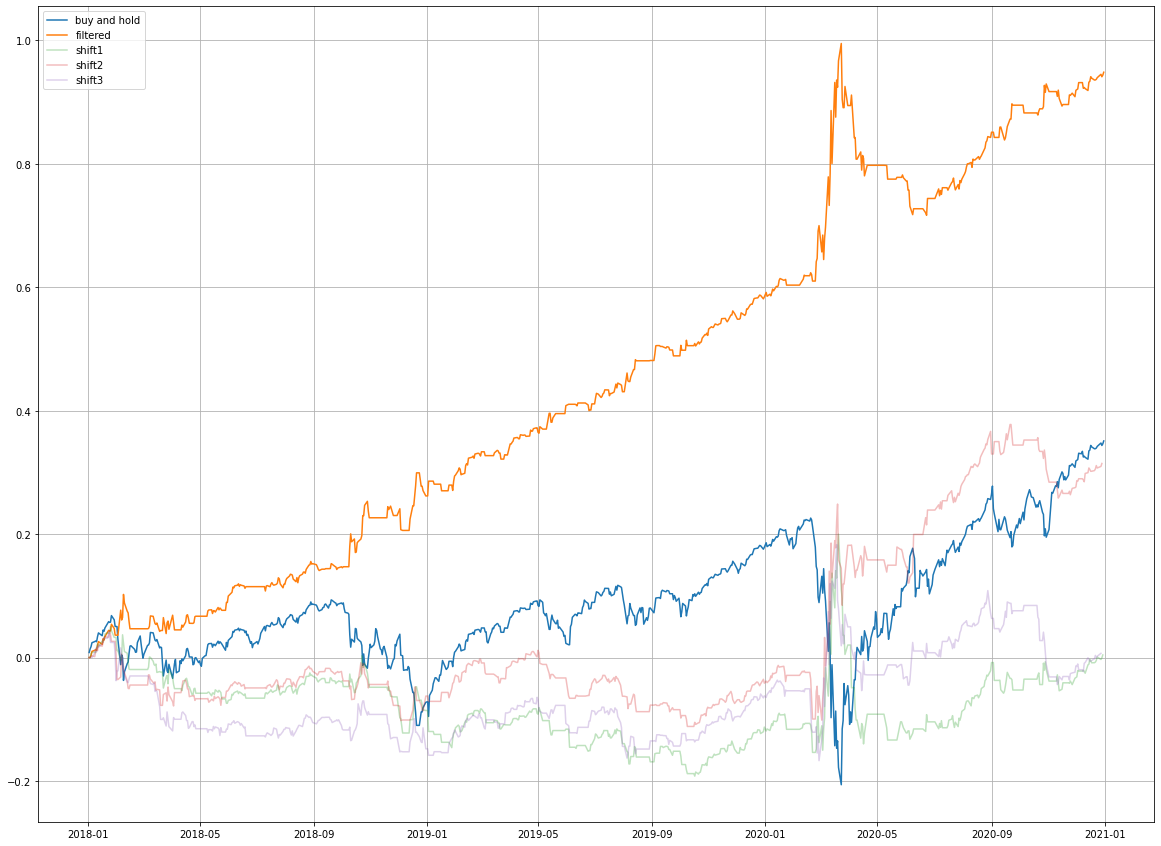

In [ ]:
# testing set plot

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_filtered_test).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_filtered_test).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-2) * label_filtered_test).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-3) * label_filtered_test).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [ ]:
pd.DataFrame({'HMM1_MA10':label_filtered_result},index = df_train.index).to_csv('gdrive/My Drive/HMM1_MA10_train.csv')
pd.DataFrame({'HMM1_MA10':label_filtered_test},index = df_test.index).to_csv('gdrive/My Drive/HMM1_MA10_test.csv')


## Two regimes, switching mean and variance with other dependent variables in transition prob.

In [ ]:
df,df_train,df_test = reReadData()
print(df,df_train,df_test)

             PX_LAST     PX_VOLUME  ...  Russell3000_Volume   log_ret
Date                                ...                              
2010-01-04   2925.36  1.300478e+09  ...                 0.0  0.016581
2010-01-05   2933.82  1.526207e+09  ...                 0.0  0.002887
2010-01-06   2937.47  1.441448e+09  ...                 0.0  0.000871
2010-01-07   2949.90  1.560355e+09  ...                 0.0  0.004177
2010-01-08   2959.37  1.311918e+09  ...                 0.0  0.003207
...              ...           ...  ...                 ...       ...
2020-12-24  12137.42  4.731720e+08  ...           1923800.0  0.002687
2020-12-28  12203.97  1.000688e+09  ...                 0.0  0.005468
2020-12-29  12155.89  9.592605e+08  ...                 0.0 -0.003953
2020-12-30  12189.07  8.921701e+08  ...                 0.0  0.002573
2020-12-31  12248.16  1.075550e+09  ...           3514200.0  0.004761

[2771 rows x 45 columns]             PX_LAST     PX_VOLUME  ...  Russell3000_Volume   log

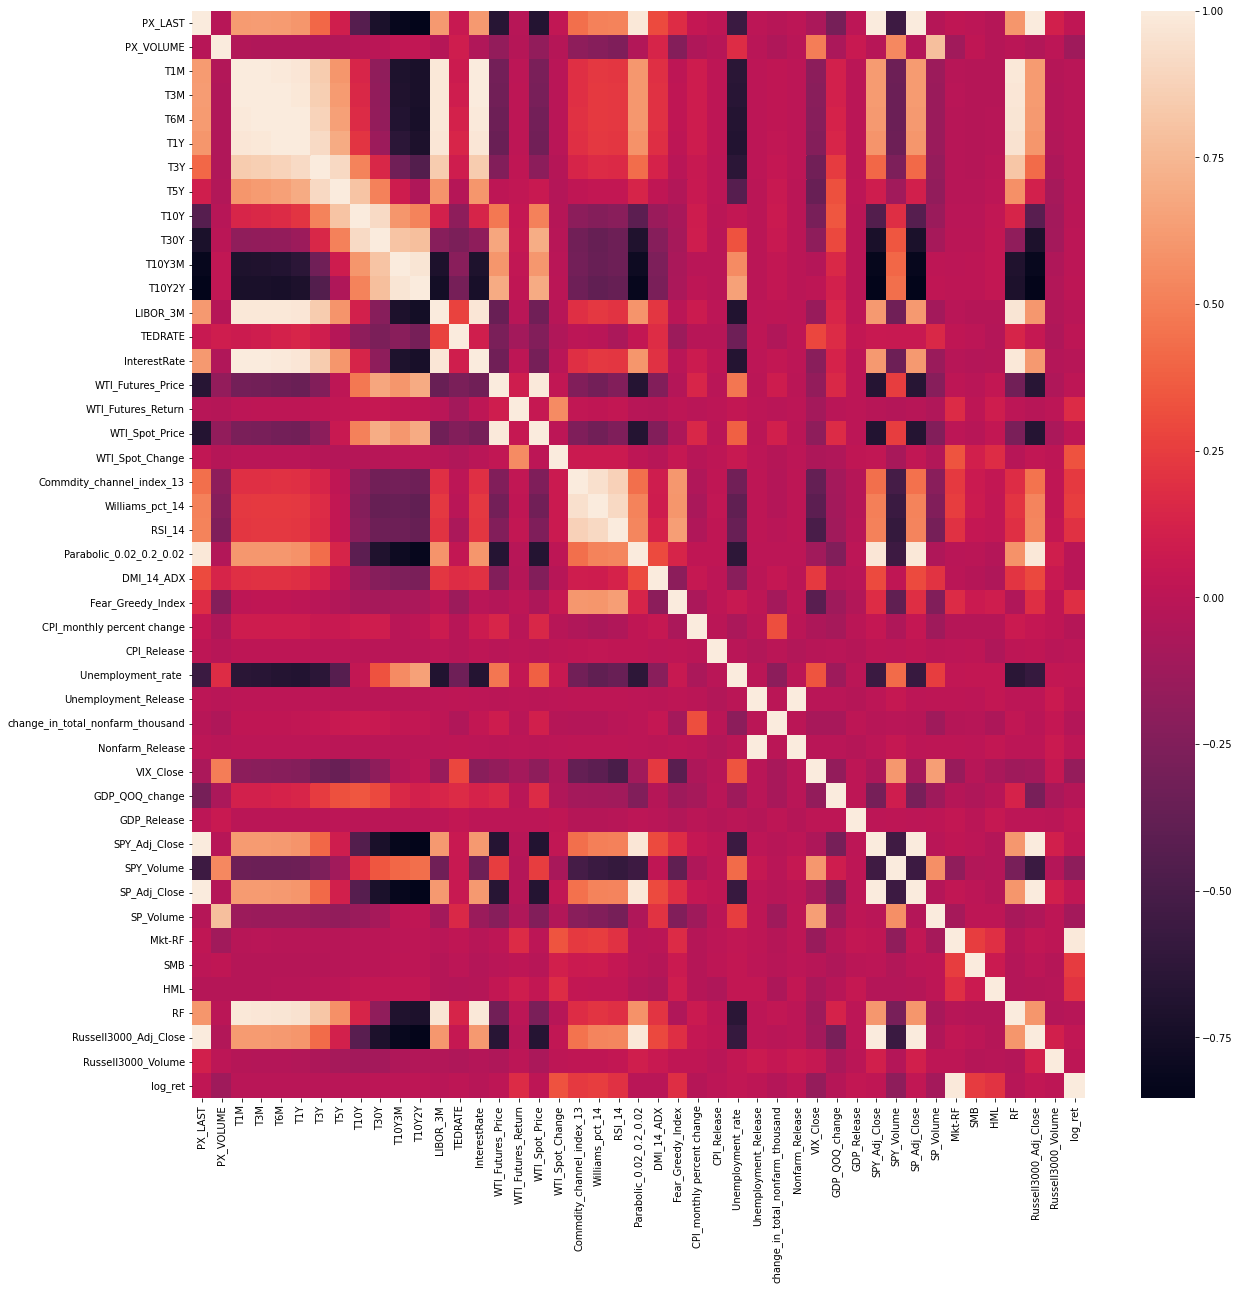

In [ ]:
import seaborn as sns
%matplotlib inline

Var_Corr = df.corr()

# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

In [ ]:
for i,j in zip (df[df.columns.to_list()].apply(lambda x: x.autocorr()) , df.columns):
  print(j,i)

PX_LAST 0.999459968779482
PX_VOLUME 0.38970790046933973
T1M 0.9994411023773713
T3M 0.9997074951999736
T6M 0.999741703636498
T1Y 0.9997055018861333
T3Y 0.998646519374297
T5Y 0.9976177840346693
T10Y 0.9974611585043354
T30Y 0.9977712251859051
T10Y3M 0.9986231537676963
T10Y2Y 0.9990657674226524
LIBOR_3M 0.9998658844591845
TEDRATE 0.9897896905296767
InterestRate 0.9991879749899127
WTI_Futures_Price 0.9964764566191465
WTI_Futures_Return 0.2842220258223691
WTI_Spot_Price 0.9984757650876693
WTI_Spot_Change 0.06708353831371544
Commdity_channel_index_13 0.8790362125595236
Williams_pct_14 0.8889138504742304
RSI_14 0.9434262203568493
Parabolic_0.02_0.2_0.02 0.9995561796608937
DMI_14_ADX 0.9926138990177905
Fear_Greedy_Index 0.9655645960960348
CPI_monthly percent change 0.969509307664759
CPI_Release -0.04614220877458386
Unemployment_rate  0.9957960100210852
Unemployment_Release -0.048720011201015025
change_in_total_nonfarm_thousand 0.94890242536816
Nonfarm_Release -0.048720011201015025
VIX_Close 0.9

In [ ]:
pd.options.mode.use_inf_as_na = True
df_train.columns[df_test.isna().any()].tolist()

[]

In [ ]:
# dependent variables used for transition prob.
# hmm1 smoothed state is not measurable; others contain nan

df_train_tvtp = df_train.drop( columns= ['Russell3000_Volume'])
df_train_tvtp = df_train_tvtp.dropna()

mean,std = df_train_tvtp.mean(),df_train_tvtp.std()

df_train_tvtp = (df_train_tvtp-df_train_tvtp.mean())/df_train_tvtp.std()
df_train_tvtp['ones'] = 1
df_train_tvtp

,PX_LAST,PX_VOLUME,T1M,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,CPI_Release,Unemployment_rate,Unemployment_Release,change_in_total_nonfarm_thousand,Nonfarm_Release,VIX_Close,GDP_QOQ_change,GDP_Release,SPY_Adj_Close,SPY_Volume,SP_Adj_Close,SP_Volume,Mkt-RF,SMB,HML,RF,Russell3000_Adj_Close,log_ret,log_ret_MA5,ones
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-08,-1.390529,0.497489,-0.577346,-0.523807,-0.396719,-0.035119,1.608794,2.332224,2.606500,2.268328,2.459131,1.847385,-0.710820,-0.761408,-0.521923,0.315674,0.050204,0.323199,0.131686,-0.800242,-0.939364,-0.960118,-1.251563,-0.224908,-0.498580,0.790563,-0.212593,1.629356,4.540198,-3.838582,4.540198,0.179097,-0.439770,-0.125095,-1.366305,-0.146447,-1.372698,0.755641,0.287083,0.702838,0.029625,-0.549195,-1.402400,0.289780,1.253239,1
2010-01-11,-1.387860,0.291758,-0.613353,-0.556288,-0.457346,-0.090188,1.584124,2.353447,2.642205,2.331823,2.504635,1.896075,-0.710820,-0.670217,-0.521923,0.305848,-0.139004,0.286025,-0.520570,-0.800242,-0.939364,-0.960118,-1.251563,-0.224908,-0.498580,0.790563,-0.212593,1.629356,-0.220145,-3.838582,-0.220145,0.081429,-0.439770,-0.125095,-1.363466,-0.405015,-1.368136,0.597899,0.078059,-0.254561,-0.509904,-0.549195,-1.398985,0.093493,0.505036,1
2010-01-12,-1.408350,0.860054,-0.577346,-0.523807,-0.427032,-0.117722,1.460772,2.162440,2.445825,2.141336,2.322619,1.766235,-0.710820,-0.761408,-0.521923,0.231933,-1.021973,0.203558,-1.162943,-0.800242,-0.939364,-0.960118,-1.251563,-0.224908,-0.498580,0.790563,-0.212593,1.629356,-0.220145,-3.838582,-0.220145,0.199304,-0.439770,-0.125095,-1.382452,0.330361,-1.392680,1.140619,-1.102924,-0.331152,-2.647268,-0.549195,-1.425227,-1.110852,-0.137996,1
2010-01-13,-1.390154,0.472337,-0.577346,-0.491327,-0.396719,-0.035119,1.559454,2.289778,2.552941,2.284202,2.398459,1.782465,-0.710820,-0.852600,-0.521923,0.183226,-0.687221,0.184330,-0.278444,-0.800242,-0.939364,-0.960118,-1.251563,-0.224908,-0.498580,0.790563,-0.212593,1.629356,-0.220145,-3.838582,-0.220145,0.131947,-0.439770,-0.125095,-1.365418,0.310846,-1.371101,0.497202,0.830544,0.511359,0.693661,-0.549195,-1.402208,0.891240,0.259447,1
2010-01-14,-1.385294,0.326869,-0.577346,-0.523807,-0.427032,-0.117722,1.436101,2.204886,2.481530,2.157210,2.352955,1.766235,-0.710820,-0.761408,-0.521923,0.172117,-0.163262,0.164248,-0.293268,-0.800242,-0.939364,-0.960118,-1.251563,-0.224908,-0.498580,0.790563,-0.212593,1.629356,-0.220145,-3.838582,-0.220145,0.094901,-0.439770,-0.125095,-1.359917,-0.284387,-1.364760,0.196407,0.193022,0.530507,0.174883,-0.549195,-1.396031,0.205082,0.172037,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,2.167050,-1.003005,3.491435,3.633703,3.725971,3.709523,2.718966,1.674313,0.196380,-0.700094,-1.530039,-1.885511,3.500953,0.880034,3.782087,-0.721695,0.089015,-0.722377,0.255219,0.940693,1.095108,1.624525,1.825391,1.783545,0.241108,0.790563,-0.212593,-1.459560,-0.220145,0.140264,-0.220145,-1.206770,0.464039,-0.125095,2.184355,-0.762063,2.136399,-1.589987,-0.130965,-0.407744,-0.426899,2.968103,2.114797,-0.095827,0.084565,1
2017-12-26,2.162911,-1.298984,3.815497,4.088430,3.665343,3.764591,2.743636,1.653090,0.178527,-0.715968,-1.757559,-1.917971,3.500953,0.880034,3.782087,-0.657607,1.141786,-0.665121,1.129835,0.778046,1.004254,1.510269,1.833066,1.832743,0.175871,0.790563,-0.212593,-1.459560,-0.220145,0.140264,-0.220145,-1.147833,0.464039,-0.125095,2.177675,-1.194274,2.129921,-2.098131,-0.130965,0.607098,-0.157135,2.968103,2.110001,-0.126728,-0.259354,1
2017-12-27,2.167329,-1.268482,3.599456,3.990989,3.695657,3.764591,2.669625,1.589421,0.089264,-0.827085,-1.787895,-1.950

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df_train_tvtp)
principalDf_train = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])
principalDf_train

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,-4.721869,3.196954,-4.390917,-0.097275,1.585277
1,-4.730731,3.331071,-4.043824,0.731407,-0.265965
2,-4.927795,4.262383,-2.593591,2.536628,-0.306864
3,-4.708447,3.266423,-4.200992,-0.203109,0.197512
4,-4.594446,3.103838,-3.900365,0.244621,-0.179017
...,...,...,...,...,...
2006,10.765113,3.575567,-1.729675,-0.307335,-2.506327
2007,11.022024,3.392679,-2.023849,-1.302560,-2.746696
2008,10.878436,3.510465,-1.752452,-0.036054,-2.868199
2009,11.048271,3.137160,-2.088736,-0.672451,-2.714104


In [ ]:
pca.explained_variance_ratio_.sum()

0.6572294708917775

In [ ]:
hmm2 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog_tvtp = principalDf_train,
                                    switching_variance=True)
hmm2_results = hmm2.fit(search_reps = 100)
print(hmm2_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA5   No. Observations:                 2011
Model:               MarkovRegression   Log Likelihood                8668.986
Date:                Wed, 09 Feb 2022   AIC                         -17309.972
Time:                        23:05:54   BIC                         -17231.483
Sample:                             0   HQIC                        -17281.161
                               - 2011                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.000     -5.558      0.000      -0.001      -0.001
sigma2      2.891e-05   1.46e-06     19.863      0.0

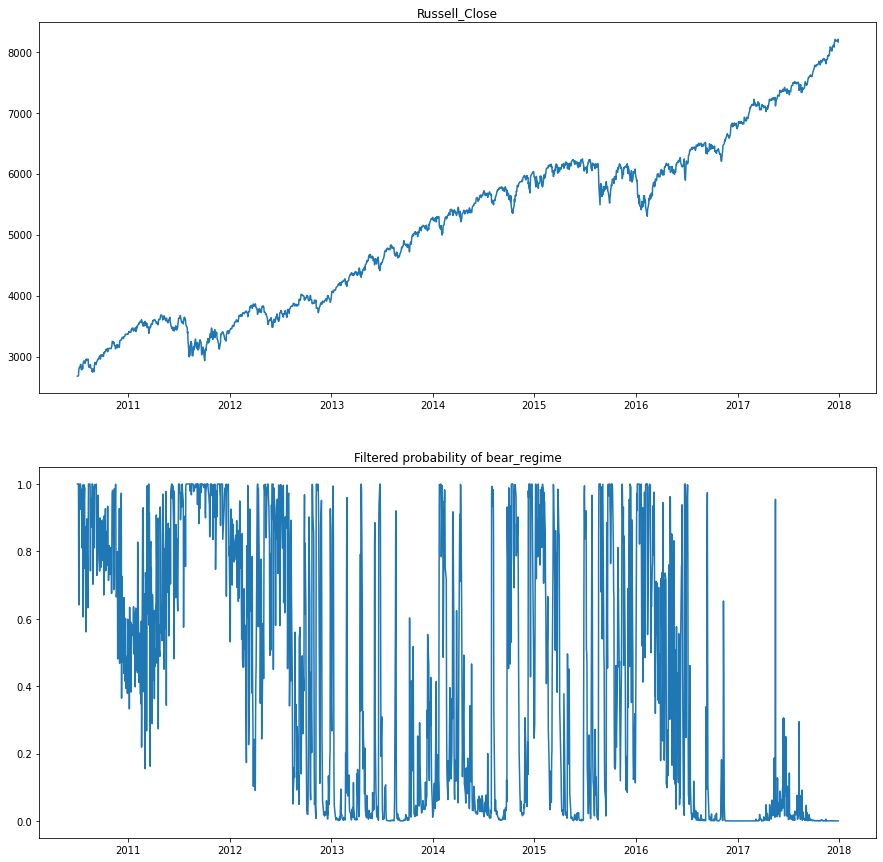

In [ ]:
plotProb_train(hmm2_results)

In [ ]:
pd.options.mode.use_inf_as_na = True
df_test.columns[df_test.isna().any()].tolist()

[]

In [ ]:
df_test_tvtp = df_test.drop( columns= ['Russell3000_Volume'])
df_test_tvtp = df_test_tvtp.dropna()

df_test_tvtp = (df_test_tvtp-mean)/std
df_test_tvtp['ones'] = 1

df_test_tvtp

,PX_LAST,PX_VOLUME,T1M,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,CPI_Release,Unemployment_rate,Unemployment_Release,change_in_total_nonfarm_thousand,Nonfarm_Release,VIX_Close,GDP_QOQ_change,GDP_Release,SPY_Adj_Close,SPY_Volume,SP_Adj_Close,SP_Volume,Mkt-RF,SMB,HML,RF,Russell3000_Adj_Close,log_ret,log_ret_MA5,ones
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2.196539,-0.345377,3.995532,3.990989,3.938168,3.984864,2.718966,1.653090,0.160675,-0.731842,-1.727223,-1.934201,3.533513,-0.031878,3.782087,-0.640517,0.103570,-0.638629,0.136627,1.082631,1.529853,1.511224,1.829703,1.871149,0.312560,0.790563,-0.212593,-1.459560,-0.220145,0.140264,-0.220145,-1.228661,0.464039,-0.125095,2.210653,-0.659618,2.164844,-0.449544,0.830544,0.664542,-0.468401,3.847428,2.144031,0.814879,0.128402,1
2018-01-03,2.229283,-0.357804,3.995532,3.893547,3.877540,3.929796,2.743636,1.653090,0.124969,-0.779464,-1.712055,-1.999121,3.530580,0.241695,3.782087,-0.586684,1.010796,-0.578381,1.149601,2.332842,1.483772,1.845800,1.829703,1.980689,0.652403,0.790563,-0.212593,-1.459560,-0.220145,0.140264,-0.220145,-1.333064,0.464039,-0.125095,2.246137,-0.615531,2.204193,-0.247477,0.558813,-0.733260,-0.364646,3.847428,2.179788,0.562582,0.452582,1
2018-01-04,2.250739,-0.131512,3.959525,3.893547,3.907854,3.957330,2.817648,1.695535,0.160675,-0.763590,-1.681719,-1.999121,3.553754,0.241695,3.782087,-0.570448,0.297629,-0.573681,0.087214,2.649221,1.358052,2.028898,1.832429,2.176215,1.071577,0.790563,-0.212593,-1.459560,-0.220145,0.140264,-0.220145,-1.321277,0.464039,-0.125095,2.269931,-0.737332,2.229125,-0.062870,0.381143,-0.522632,0.486150,3.847428,2.202155,0.333422,0.594543,1
2018-01-05,2.287097,-0.473026,3.923518,3.828586,3.847226,3.902262,2.842318,1.737981,0.178527,-0.731842,-1.636215,-1.982891,3.554047,0.424078,3.782087,-0.594801,-0.449499,-0.589491,-0.298210,2.238641,1.531351,2.311708,1.837761,2.433050,1.449175,0.790563,-0.212593,-1.513751,4.540198,-0.005200,4.540198,-1.321277,0.464039,-0.125095,2.307710,-0.700051,2.272830,-0.603537,0.631971,-0.675816,-0.509904,3.847428,2.241863,0.623155,0.807114,1
2018-01-08,2.297642,-0.288737,4.031539,4.023469,3.907854,3.874728,2.866989,1.737981,0.214233,-0.731842,-1.696887,-1.950431,3.566074,-0.031878,3.782087,-0.582411,0.224857,-0.560435,0.472638,1.767978,1.507119,2.385366,1.846244,2.701012,1.731355,0.790563,-0.212593,-1.513751,-0.220145,-0.005200,-0.220145,-1.270759,0.464039,-0.125095,2.318147,-1.038378,2.283231,-0.596429,0.140766,-0.292856,0.091879,3.847428,2.253296,0.146852,1.165373,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,4.857308,-1.784879,-0.325298,-0.393885,-0.578602,-0.778541,-1.820401,-2.336825,-2.552941,-2.557342,-1.985078,-1.495991,-0.739773,-1.217365,-0.587633,-1.159202,0.108421,-1.156503,0.195923,1.031927,1.182362,1.524379,3.613266,1.566434,0.036934,0.298967,-0.212593,-0.104772,-0.220145,0.722116,-0.220145,0.751630,20.412407,-0.125095,4.746915,-1.436825,4.462446,-2.196789,0.161668,-0.771556,-0.385397,-0.549195,4.571647,0.235550,-0.184158,1
2020-12-28,4.902611,-0.349420,-0.325298,-0.328924,-0.517974,-0.751007,-1.820401,-2.315602,-2.552941,-2.541468,-2.015414,-1.495991,-0.739773,-1.217365,-0.587633,-1.185265,-0.614449,-1.174022,-0.065967,1.427574,1.328656,1.743914,3.621852,1.611343,0.631975,0.298967,-0.212593,-0.104772,-0.220145,0.722116,-0.220145,0.780257,20.412407,-0.125095,4.816895,-1.274890,4.536124,-0.260681,0.422948,-1.403439,0.714412,-0.549195,4.618530,0.525590,0.197729,1
2020-12-29,4.869881,-0.462151,-0.361305,-0.361405,-0.487660,-0.751007,-1.820401,-2.336825,-2.552941,-2.541468,-2.000246,-1.479761,-0.699438,-1.217365,-0.5

In [ ]:
principalComponents = pca.transform(df_test_tvtp)
principalDf_test = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])
principalDf_test

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,11.162851,3.980014,-2.437269,-1.343886,-2.023997
1,11.443826,3.469111,-2.742077,-1.569043,-1.892871
2,11.550466,3.530887,-2.714238,-0.877117,-1.862460
3,11.673156,3.295829,-2.740740,-0.177401,-0.619803
4,11.742784,3.302460,-3.066988,-0.691673,-2.126541
...,...,...,...,...,...
751,6.775615,-4.764607,2.339804,2.632974,5.646690
752,6.786234,-4.303346,2.280312,2.506643,6.716378
753,6.478345,-3.702988,2.967508,2.978794,6.343974
754,6.590272,-4.392160,2.151127,1.587899,6.893700


In [1]:
#using the same probability filter constructed from the training set
hmm2_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',exog_tvtp = principalDf_test,
                                    switching_variance=True)
hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)
plotProb_test(hmm2_test_results)

NameError: ignored

In [ ]:
t1,t2 = Search_train(hmm2_results, duration_static, duration_bear)
print(t1,t2)

0.67 0.01


In [ ]:
label_filtered_results = labeling(hmm2_results,t1,t2)
print((duration(label_filtered_results))[0].mean())
print((duration(label_filtered_results))[1].mean())
print((duration(label_filtered_results))[2].mean())
print((duration(label_filtered_results))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered_results))

0    8.835294
dtype: float64
0    2.054852
dtype: float64
0    4.010363
dtype: float64
514
0.8606395755431349 3.0447297313015644


In [ ]:
np.histogram(label_filtered_results)

(array([774,   0,   0,   0,   0, 487,   0,   0,   0, 750]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

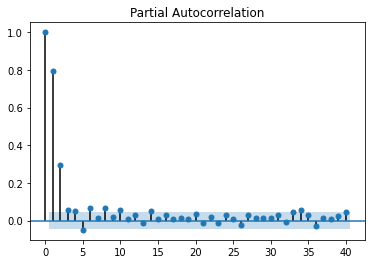

array([ 1.        ,  0.79167727,  0.29679066,  0.05499376,  0.04850279,
       -0.04972588,  0.06557157,  0.01252398,  0.06892064,  0.0182558 ,
        0.0576904 ,  0.01087811,  0.03082345, -0.01332882,  0.05316159,
        0.0060292 ,  0.03010983,  0.00985222,  0.01351814,  0.00969838,
        0.03353387, -0.0138754 ,  0.02131658, -0.01412671,  0.02808167,
        0.00729871, -0.02114108,  0.02749246,  0.01259441,  0.01619168,
        0.01158848,  0.0286296 , -0.00880302,  0.04663309,  0.05403895,
        0.02813578, -0.03138735,  0.01312227,  0.009206  ,  0.02203713,
        0.04606089])

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered_results, lags=40)
plt.show()
sm.tsa.pacf(label_filtered_results)

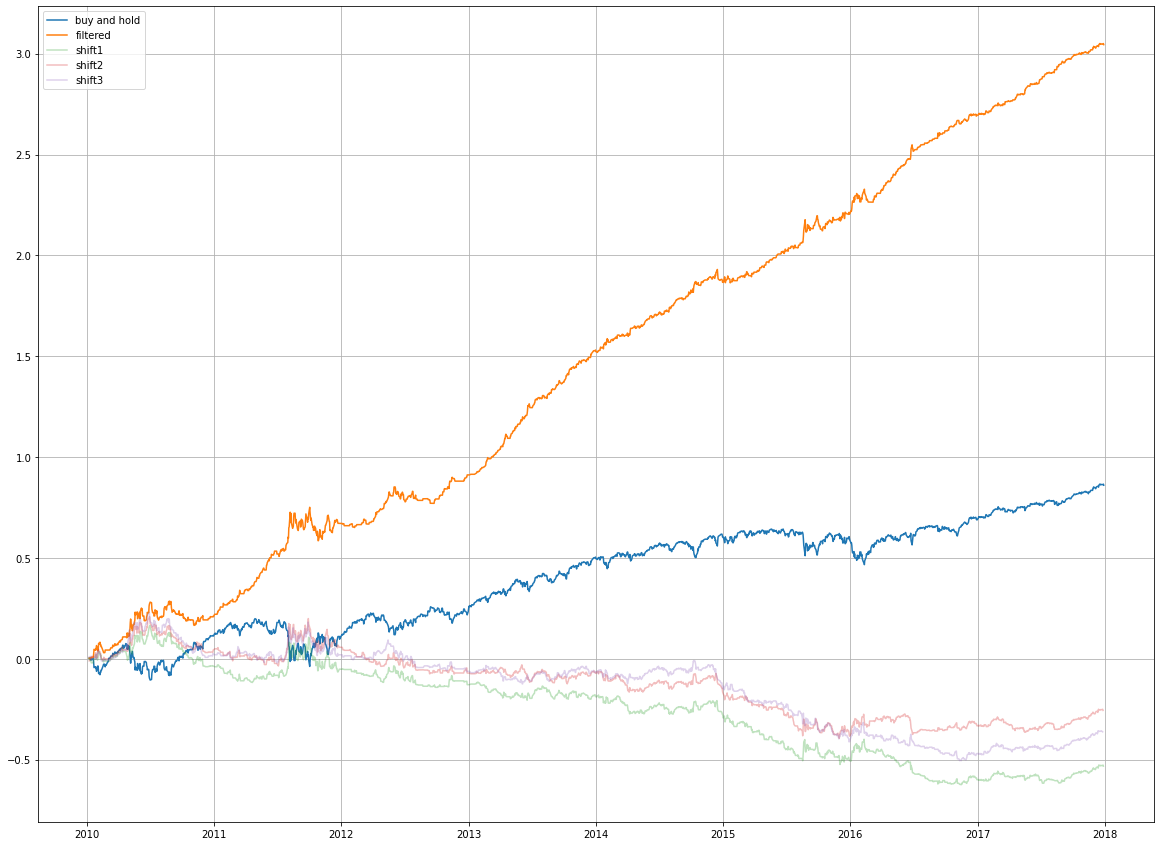

In [ ]:
# training set plot

fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_filtered_results).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_filtered_results).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-2) * label_filtered_results).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-3) * label_filtered_results).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [ ]:
label_filtered = labeling(hmm2_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    6.974026
dtype: float64
0    1.592593
dtype: float64
0    2.163934
dtype: float64
191
0.4205309960530377 2.130431915912745


In [ ]:
np.histogram(label_filtered)

(array([132,   0,   0,   0,   0,  86,   0,   0,   0, 536]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

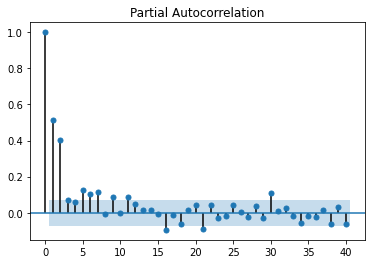

array([ 1.        ,  0.51297424,  0.40562503,  0.0694907 ,  0.0623039 ,
        0.12782386,  0.10662555,  0.11544553, -0.00534854,  0.0881292 ,
        0.00121697,  0.08869077,  0.04741945,  0.01383307,  0.01707039,
       -0.00788409, -0.09511421, -0.01133476, -0.06473742,  0.01738973,
        0.04386247, -0.09104853,  0.04291746, -0.0295915 , -0.01913317,
        0.04064439,  0.00633255, -0.02473427,  0.03688013, -0.02718583,
        0.10684699,  0.010787  ,  0.02683073, -0.01561762, -0.05563047,
       -0.01772153, -0.02226352,  0.01604428, -0.06038188,  0.03133852,
       -0.06392858])

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

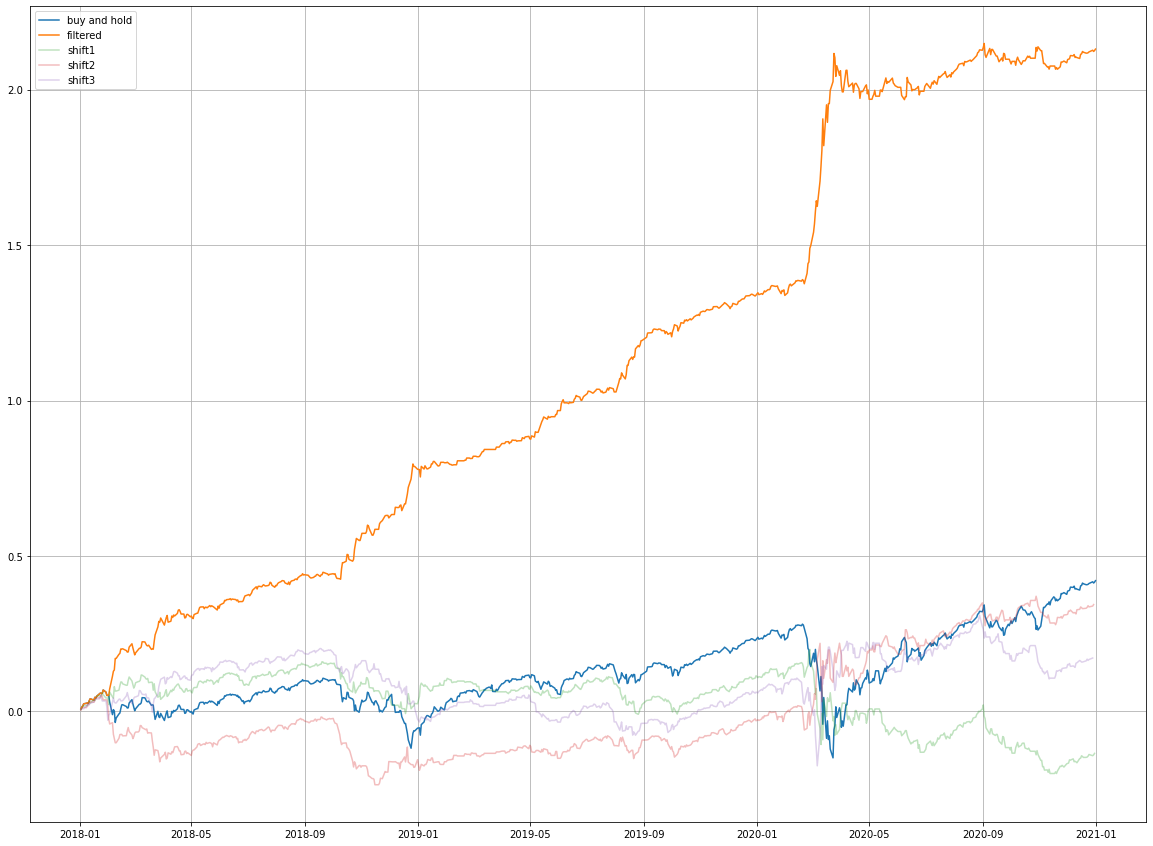

In [ ]:
# testing set plot

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

## Two regimes, switching mean and variance with other dependent variables in transition prob. and mean.

In [ ]:
# switching mean dependent variabels
df_train_exog = df_train[['SMB','HML']]
df_test_exog = df_test[['SMB','HML']]

In [ ]:
hmm3 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = df_train_exog, 
                               exog_tvtp = principalDf_train, switching_exog = True, switching_variance=True)
hmm3_results = hmm3.fit(search_reps = 100)
print(hmm3_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA5   No. Observations:                 1885
Model:               MarkovRegression   Log Likelihood                8121.053
Date:                Wed, 09 Feb 2022   AIC                         -16206.105
Time:                        04:29:45   BIC                         -16106.355
Sample:                             0   HQIC                        -16169.369
                               - 1885                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.000     -3.502      0.000      -0.001      -0.000
x1             0.0013      0.000      3.888      0.0

In [ ]:
t1,t2 = Search_train(hmm3_results, duration_static, duration_bear)
print(t1,t2)

0.28 0.03


In [ ]:
label_filtered = labeling(hmm3_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    3.924528
dtype: float64
0    2.0
dtype: float64
0    4.204444
dtype: float64
592
1.077502078603306 1.6675514898258235


In [ ]:
np.histogram(label_filtered)

(array([946,   0,   0,   0,   0, 524,   0,   0,   0, 415]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

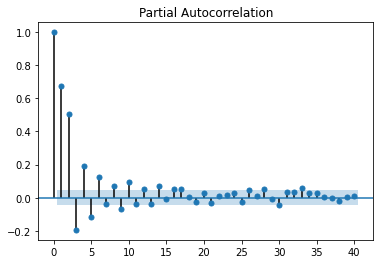

array([ 1.        ,  0.67257633,  0.50611021, -0.19497179,  0.19243326,
       -0.11733567,  0.12448637, -0.04127957,  0.07001122, -0.06822669,
        0.09282134, -0.04058784,  0.05264197, -0.04107628,  0.06815841,
       -0.00739306,  0.05487185,  0.05396991,  0.00515186, -0.02905643,
        0.02760413, -0.03417768,  0.00705186,  0.01703719,  0.03114174,
       -0.02866365,  0.04684598,  0.00859697,  0.04997097, -0.00916212,
       -0.04505344,  0.03451688,  0.03584322,  0.05955553,  0.02730345,
        0.02610577,  0.00103161, -0.00153152, -0.02089111,  0.00642824,
        0.01166218])

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [ ]:
hmm3_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = df_test_exog, 
                               exog_tvtp = principalDf_test, switching_exog = True,switching_variance=True)
hmm3_test_results = hmm3_test.fit(start_params = hmm3_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
label_filtered = labeling(hmm3_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    1.097701
dtype: float64
0    1.110169
dtype: float64
0    1.621723
dtype: float64
558
0.4205309960530377 1.1610542529179186


In [ ]:
np.histogram(label_filtered)

(array([433,   0,   0,   0,   0, 131,   0,   0,   0, 190]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

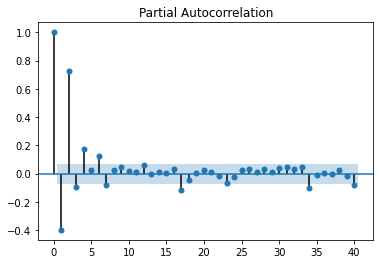

array([ 1.00000000e+00, -3.97854407e-01,  7.27851213e-01, -9.74075788e-02,
        1.72554629e-01,  2.56056266e-02,  1.25070222e-01, -8.06155152e-02,
        2.91552803e-02,  4.89812498e-02,  1.83278454e-02,  1.25079190e-02,
        6.27117561e-02, -2.07928252e-04,  1.43692442e-02,  6.69376507e-03,
        3.08000474e-02, -1.17306682e-01, -4.38249579e-02,  3.69141333e-03,
        2.84146812e-02,  1.31496571e-02, -1.54995125e-02, -6.76369746e-02,
       -2.41957656e-02,  2.40402506e-02,  3.41270130e-02,  1.35127279e-02,
        3.37249576e-02,  1.33020956e-02,  3.65037931e-02,  4.65931965e-02,
        3.58649526e-02,  4.70278245e-02, -9.79852311e-02, -9.02752852e-03,
        1.84392142e-03, -5.44110803e-03,  2.57886033e-02, -1.90299737e-02,
       -8.17146312e-02])

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

## Two regimes, switching mean and variance with other dependent variables in mean.

In [ ]:
hmm4 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = df_train_exog, 
                                switching_exog = True,switching_variance=True)
hmm4_results = hmm4.fit(search_reps = 100)
print(hmm4_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA5   No. Observations:                 1885
Model:               MarkovRegression   Log Likelihood                8186.727
Date:                Wed, 09 Feb 2022   AIC                         -16353.455
Time:                        04:30:10   BIC                         -16298.038
Sample:                             0   HQIC                        -16333.046
                               - 1885                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.766      0.077      -0.001       5e-05
x1             0.0016      0.000      4.393      0.0

In [ ]:
t1,t2 = Search_train(hmm4_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.84 0.32


In [ ]:
label_filtered = labeling(hmm4_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    12.032967
dtype: float64
0    2.130178
dtype: float64
0    4.22549
dtype: float64
361
1.077502078603306 1.0987139223554814


In [ ]:
np.histogram(label_filtered)

(array([ 431,    0,    0,    0,    0,  360,    0,    0,    0, 1094]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

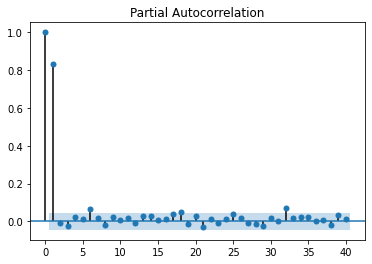

array([ 1.        ,  0.83468761, -0.00892182, -0.0249027 ,  0.02386734,
        0.01374644,  0.06424637,  0.01604257, -0.01815647,  0.02178185,
        0.00979053,  0.01801687, -0.00984463,  0.03070544,  0.03097396,
        0.00859114,  0.01157362,  0.03661321,  0.05003468, -0.01236482,
        0.02696127, -0.03114617,  0.0147467 , -0.01115931,  0.01185422,
        0.04078744,  0.01795157, -0.00887649, -0.01221429, -0.023353  ,
        0.01898905,  0.00145745,  0.07118235,  0.0191246 ,  0.02387695,
        0.02293117,  0.00246928,  0.00568497, -0.01797088,  0.03375987,
        0.01018258])

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [ ]:
hmm4_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = df_test_exog, 
                                switching_exog = True,switching_variance=True)
hmm4_test_results = hmm4_test.fit(start_params = hmm4_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
label_filtered = labeling(hmm4_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    17.6
dtype: float64
0    1.9
dtype: float64
0    4.568182
dtype: float64
128
0.4205309960530377 0.791677157746834


In [ ]:
np.histogram(label_filtered)

(array([201,   0,   0,   0,   0, 114,   0,   0,   0, 439]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

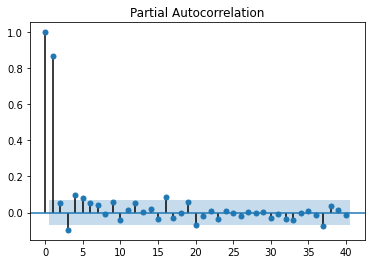

array([ 1.00000000e+00,  8.65776188e-01,  5.42151122e-02, -9.62401681e-02,
        9.95454875e-02,  8.17387639e-02,  5.40723992e-02,  3.92519637e-02,
       -1.06416385e-02,  6.11243742e-02, -4.10457054e-02,  1.27381767e-02,
        5.49964876e-02,  2.93042065e-03,  1.94196882e-02, -3.51844254e-02,
        8.74953821e-02, -2.86963179e-02, -3.51882780e-03,  5.58611913e-02,
       -6.82873272e-02, -1.68513824e-02,  1.11120986e-02, -3.43880186e-02,
        6.72287808e-03, -3.75575054e-04, -2.12921080e-02,  2.40955092e-03,
       -1.82766012e-03,  2.74890081e-03, -3.14284137e-02, -5.93309372e-03,
       -3.34965257e-02, -4.04073081e-02, -5.39408063e-04,  1.12031358e-02,
       -1.43483811e-02, -7.32243285e-02,  3.65536389e-02,  1.55047177e-02,
       -1.32480612e-02])

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [ ]:
hmm5 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = principalDf_train, 
                                switching_exog = True,switching_variance=True)
hmm5_results = hmm5.fit(search_reps = 100)
print(hmm5_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA5   No. Observations:                 1885
Model:               MarkovRegression   Log Likelihood                8338.963
Date:                Wed, 09 Feb 2022   AIC                         -16645.925
Time:                        04:30:35   BIC                         -16557.259
Sample:                             0   HQIC                        -16613.271
                               - 1885                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.000     -1.834      0.067      -0.001    4.82e-05
x1         -8.344e-05   5.13e-05     -1.625      0.1

This model labels the observables from a perspective fairly different from bear and bull concept.

In [ ]:
t1,t2 = Search_train(hmm5_results, duration_static, duration_bear)
print(t1,t2)

0.88 0.17


In [ ]:
label_filtered = labeling(hmm4_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    10.182796
dtype: float64
0    2.945652
dtype: float64
0    3.745283
dtype: float64
382
1.077502078603306 1.0249337417040025


In [ ]:
np.histogram(label_filtered)

(array([397,   0,   0,   0,   0, 542,   0,   0,   0, 946]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

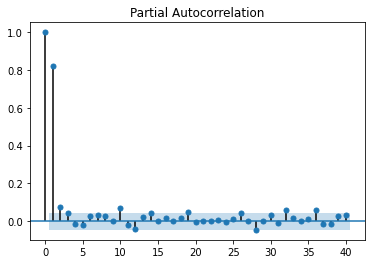

array([ 1.00000000e+00,  8.22020202e-01,  7.65533101e-02,  4.37606732e-02,
       -1.69757065e-02, -2.11647665e-02,  2.60799461e-02,  3.35621719e-02,
        2.83860944e-02,  2.18745005e-03,  6.81276643e-02, -1.90817088e-02,
       -4.28369461e-02,  2.42934108e-02,  4.37700237e-02, -3.22322520e-04,
        1.85097235e-02,  1.53494526e-03,  1.81519996e-02,  5.01730349e-02,
       -3.90563345e-03,  1.54869268e-03,  1.23010090e-03,  6.00420667e-03,
       -3.11407508e-03,  1.40033827e-02,  4.40558304e-02,  3.51628526e-03,
       -4.61043669e-02,  5.27753645e-04,  3.52907682e-02, -8.02948890e-03,
        5.98045701e-02,  1.69131637e-02, -1.12526563e-03,  1.37182939e-02,
        5.78147197e-02, -1.57134449e-02, -1.42639320e-02,  2.91033475e-02,
        3.09230482e-02])

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [ ]:
hmm5_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = principalDf_test, 
                                switching_exog = True, switching_variance=True)
hmm5_test_results = hmm5_test.fit(start_params = hmm5_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
label_filtered = labeling(hmm4_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    16.4
dtype: float64
0    2.421875
dtype: float64
0    4.318182
dtype: float64
132
0.4205309960530377 0.8975161370738162


In [ ]:
np.histogram(label_filtered)

(array([190,   0,   0,   0,   0, 155,   0,   0,   0, 409]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

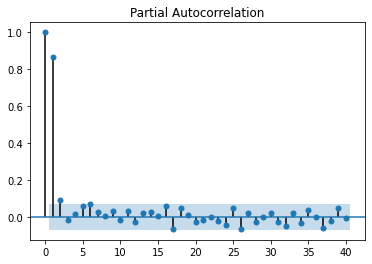

array([ 1.00000000e+00,  8.65726727e-01,  9.10688211e-02, -1.68305016e-02,
        1.30497394e-02,  6.02280846e-02,  6.95965785e-02,  2.32177022e-02,
        1.81820720e-03,  3.25162014e-02, -1.55606353e-02,  2.96926630e-02,
       -3.07549273e-02,  2.05190434e-02,  2.58696953e-02,  2.81234706e-03,
        5.97009305e-02, -6.80227730e-02,  4.80287455e-02,  1.05832852e-02,
       -3.10766360e-02, -1.73447503e-02, -4.43074665e-05, -2.08898430e-02,
       -4.33081701e-02,  4.97220047e-02, -6.79945476e-02,  2.27273880e-02,
       -2.93214972e-02,  1.44413402e-04,  1.80213042e-02, -2.71139743e-02,
       -4.85400827e-02,  1.94375010e-02, -3.29764155e-02,  3.60770029e-02,
       -3.41991591e-03, -5.90245075e-02, -2.53091880e-02,  4.81465529e-02,
       -7.66710143e-03])

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

## Method 1
## Pick thresholds such that the durations meet certain criteria

In [ ]:
## some tech issue for this function

#from scipy.optimize import minimize
def FindTresholds(model_train):
  threshold1,threshold2 = 70,30
  label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
  duration_bear = duration(label)
  duration_bear_mean = duration_bear.mean()
    
  #find threshold1 such that the bear duration reach 4
  while(duration_bear_mean <=4 and threshold1 <=99):
    threshold1+=1
    label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
    duration_bear = duration(label)
    duration_bear_mean = duration_bear.mean()
    
  #find threshold2 that maximizes log return
  #logret_prev = label_logret(label_train_filtered)
  #for threshold2 in range(30,threshold1):
  #  label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
  #  logret = logret(label_train_filtered)
  #  if logret < logret_prev:
  #    threshold2-=1
  #    break
  #  logret_prev = logret

  return threshold1/100,threshold2/100


In [ ]:
label_filtered = labeling(hmm1_results,0.99,0.89)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    14.074766
dtype: float64
0    1.460177
dtype: float64
0    2.590361
dtype: float64
1.077502078603306 2.024608669382664


In [ ]:
np.histogram(label_filtered)

(array([ 215,    0,    0,    0,    0,  165,    0,    0,    0, 1505]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [ ]:
label_filtered = labeling(hmm1_test_results,0.99,0.89)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    12.688889
dtype: float64
0    1.525
dtype: float64
0    3.324324
dtype: float64
0.4205309960530377 1.2655462574558096


In [ ]:
np.histogram(label_filtered)

(array([123,   0,   0,   0,   0,  61,   0,   0,   0, 570]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [ ]:
label_filtered = labeling(hmm2_results,0.99, 0.45)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    9.915888
dtype: float64
0    3.55
dtype: float64
0    2.384615
dtype: float64
1.077502078603306 2.4950795759080218


In [ ]:
np.histogram(label_filtered)

(array([ 186,    0,    0,    0,    0,  639,    0,    0,    0, 1060]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [ ]:
label_filtered = labeling(hmm2_test_results,0.99, 0.45)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    7.586667
dtype: float64
0    1.571429
dtype: float64
0    1.9
dtype: float64
0.4205309960530377 1.916472995295382


In [ ]:
np.histogram(label_filtered)

(array([ 76,   0,   0,   0,   0, 110,   0,   0,   0, 568]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [ ]:
label_filtered = labeling(hmm3_results,0.99, 0.71)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    6.258373
dtype: float64
0    1.452381
dtype: float64
0    2.826667
dtype: float64
1.077502078603306 3.35703613643155


In [ ]:
np.histogram(label_filtered)

(array([ 212,    0,    0,    0,    0,  366,    0,    0,    0, 1307]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [ ]:
label_filtered = labeling(hmm3_test_results,0.99, 0.71)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    1.686275
dtype: float64
0    1.110345
dtype: float64
0    1.28125
dtype: float64
0.4205309960530377 1.8200569341943482


In [ ]:
np.histogram(label_filtered)

(array([164,   0,   0,   0,   0, 161,   0,   0,   0, 429]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [ ]:
label_filtered = labeling(hmm4_results,0.99, 0.91)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    14.371429
dtype: float64
0    1.417391
dtype: float64
0    2.45977
dtype: float64
1.077502078603306 1.926158185049821


In [ ]:
np.histogram(label_filtered)

(array([ 214,    0,    0,    0,    0,  163,    0,    0,    0, 1508]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [ ]:
label_filtered = labeling(hmm4_test_results,0.99, 0.91)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    13.395349
dtype: float64
0    1.486486
dtype: float64
0    3.179487
dtype: float64
0.4205309960530377 1.241120377994608


In [ ]:
np.histogram(label_filtered)

(array([124,   0,   0,   0,   0,  55,   0,   0,   0, 575]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))